# Calibrate the Tinytag data

CEB_1    1.0
CEB_2    1.0
CEB_3    1.0
CEB_4    1.0
CEB_5    1.0
dtype: float64


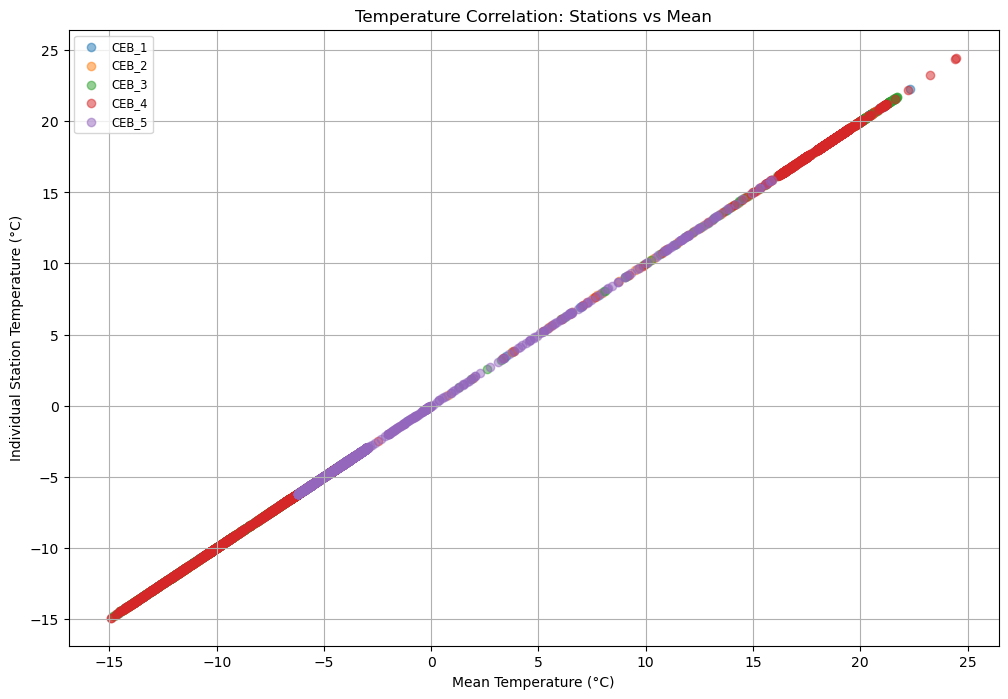

In [6]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Define the path to the Tinytag directory
tinytag_dir = 'C:/Users/rebec/OneDrive - Herbst GmbH/Pictures/Dokumente/AGF350_Svalbard/BL_Group3_wind_chanelling/Data/RawData/TinyTag'

# Find all directories that start with 'CEB_'
ceb_dirs = [d for d in os.listdir(tinytag_dir) if os.path.isdir(os.path.join(tinytag_dir, d)) and d.startswith('CEB_')]

# Initialize a dictionary to store dataframes
dataframes = {}

# Loop through each CEB directory and read the txt file inside
for ceb_dir in ceb_dirs:
    txt_files = glob.glob(os.path.join(tinytag_dir, ceb_dir, '*.txt'))
    
    if txt_files:
        file_path = txt_files[0]

        # Read the file while skipping metadata (assume first 5 rows are metadata)
        df = pd.read_csv(file_path, delimiter='\t', skiprows=5, names=["Index", "Timestamp", "Temperature"], encoding='ISO-8859-1')

        # Convert Timestamp to datetime format
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d %b %Y %H:%M:%S')

        # Remove degree symbol and convert temperature to float
        df["Temperature"] = df["Temperature"].str.replace("°C", "").astype(float)

        # Store DataFrame in dictionary with the station name
        dataframes[ceb_dir] = df.set_index("Timestamp")["Temperature"]

# Merge all datasets into a single DataFrame
all_data = pd.concat(dataframes, axis=1)

# Compute the mean temperature across all stations
mean_temp = all_data.mean(axis=1)

# Compute correlation of each station with the mean
correlations = all_data.corrwith(mean_temp)

# Print correlations
print(correlations)

# Plot each dataset against the mean temperature
plt.figure(figsize=(12, 8))

for station in all_data.columns:
    plt.scatter(mean_temp, all_data[station], label=f'{station}', alpha=0.5)

# Plot formatting
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Individual Station Temperature (°C)")
plt.title("Temperature Correlation: Stations vs Mean")
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()



Correlation of each station with the mean:
CEB_1    1.0
CEB_2    1.0
CEB_3    1.0
CEB_4    1.0
CEB_5    1.0
dtype: float64


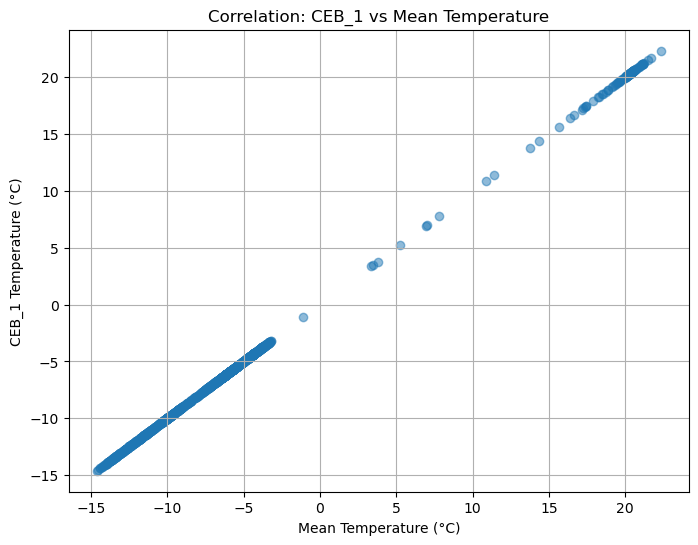

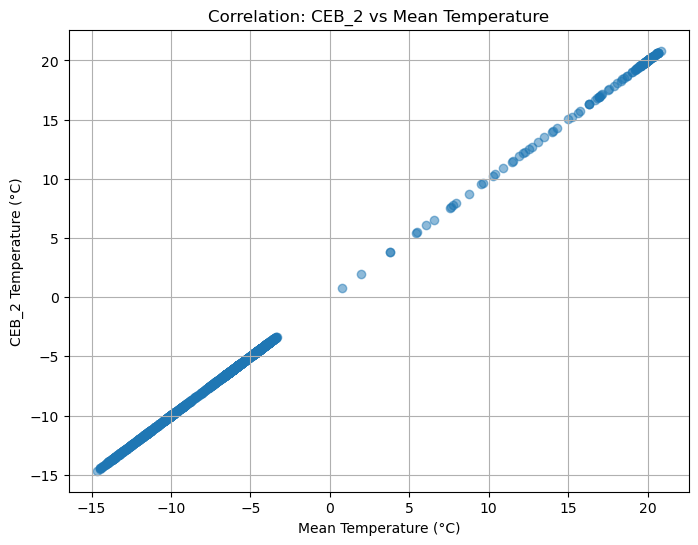

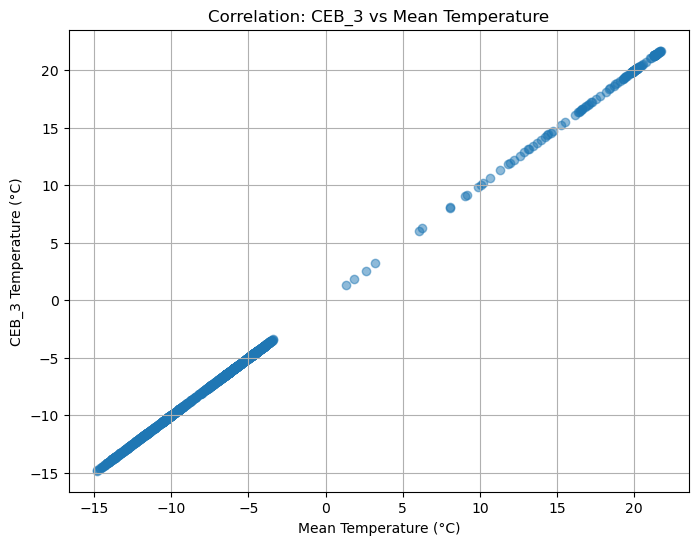

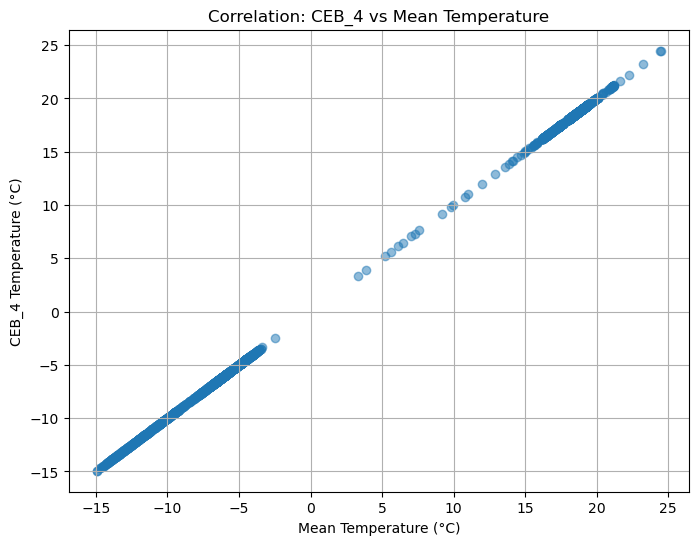

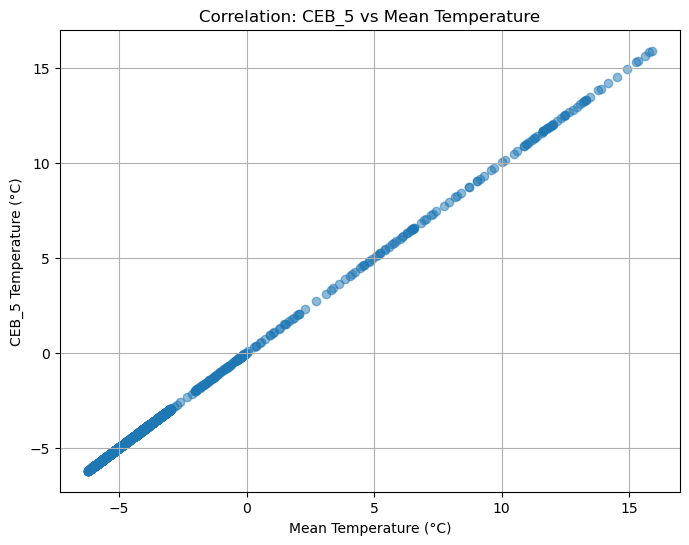

In [7]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Define the path to the Tinytag directory
tinytag_dir = 'C:/Users/rebec/OneDrive - Herbst GmbH/Pictures/Dokumente/AGF350_Svalbard/BL_Group3_wind_chanelling/Data/RawData/TinyTag'

# Find all directories that start with 'CEB_'
ceb_dirs = [d for d in os.listdir(tinytag_dir) if os.path.isdir(os.path.join(tinytag_dir, d)) and d.startswith('CEB_')]

# Initialize a dictionary to store dataframes
dataframes = {}

# Loop through each CEB directory and read the txt file inside
for ceb_dir in ceb_dirs:
    txt_files = glob.glob(os.path.join(tinytag_dir, ceb_dir, '*.txt'))
    
    if txt_files:
        file_path = txt_files[0]

        # Read the file while skipping metadata (assume first 5 rows are metadata)
        df = pd.read_csv(file_path, delimiter='\t', skiprows=5, names=["Index", "Timestamp", "Temperature"], encoding='ISO-8859-1')

        # Convert Timestamp to datetime format
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d %b %Y %H:%M:%S')

        # Remove degree symbol and convert temperature to float
        df["Temperature"] = df["Temperature"].str.replace("°C", "").astype(float)

        # Store DataFrame in dictionary with the station name
        dataframes[ceb_dir] = df.set_index("Timestamp")["Temperature"]

# Merge all datasets into a single DataFrame
all_data = pd.concat(dataframes, axis=1)

# Compute the mean temperature across all stations at each timestamp
mean_temp = all_data.mean(axis=1)

# Compute correlation of each station with the mean
correlations = all_data.corrwith(mean_temp)

# Print correlations
print("\nCorrelation of each station with the mean:")
print(correlations)

# Plot each station separately against the mean
for station in all_data.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp, all_data[station], alpha=0.5)
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Correlation: {station} vs Mean Temperature")
    plt.grid(True)
    plt.show()


In [39]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


####old version ######
# Define the path to the Tinytag directory
tinytag_dir = 'C:/Users/rebec/OneDrive - Herbst GmbH/Pictures/Dokumente/AGF350_Svalbard/BL_Group3_wind_chanelling/Data/RawData/TinyTag'

# **Find all directories that match 'CEB_*_correlation_RO'**
ceb_dirs = [d for d in os.listdir(tinytag_dir) if os.path.isdir(os.path.join(tinytag_dir, d)) and "CEB_" in d and "_calibration_RO" in d]

# Initialize a list to store dataframes
dataframes = []

# Loop through each CEB directory and read the txt file inside
for ceb_dir in ceb_dirs:
    txt_files = glob.glob(os.path.join(tinytag_dir, ceb_dir, '*.txt'))  # Find all .txt files in each directory
    
    if txt_files:
        file_path = txt_files[0]  # Assuming one file per folder

        # Read the file while skipping metadata (assume first 5 rows are metadata)
        df = pd.read_csv(file_path, delimiter='\t', skiprows=5, names=["Index", "Timestamp", "Temperature"], encoding='ISO-8859-1')

        # Convert Timestamp to datetime format
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d %b %Y %H:%M:%S')

        # **Cut the seconds off (but keep it as a column)**
        df["Timestamp"] = df["Timestamp"].astype(str).str.slice(0, 16)  # Keep only "YYYY-MM-DD HH:MM"
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M')  # Convert back to datetime

        # Remove degree symbol and convert temperature to float
        df["Temperature"] = df["Temperature"].str.replace("°C", "").astype(float)

        # Drop the "Index" column since it's not needed
        df.drop(columns=["Index"], inplace=True)

        # Rename Temperature column to match station name
        df.rename(columns={"Temperature": ceb_dir}, inplace=True)

        # Append to the list
        dataframes.append(df)

# CHeck if dataframes were loaded

if dataframes:
    all_data = dataframes[0]
else:
    print("The dataframes list is empty.")


# **Merge all datasets on Timestamp (keeping only overlapping timestamps)**
all_data = dataframes[0]
for df in dataframes[1:]:
    all_data = pd.merge(all_data, df, on="Timestamp", how="inner")  # Keep only common timestamps

# **Now set Timestamp as the index**
all_data.set_index("Timestamp", inplace=True)

# **Check timestamps before and after alignment**
print(f"\nTotal timestamps before alignment: {len(dataframes[0])}")
print(f"Total timestamps after alignment: {len(all_data)}")

# **Ensure there are still overlapping timestamps**
if all_data.empty:
    raise ValueError("No overlapping timestamps remain after aligning datasets!")



The dataframes list is empty.


IndexError: list index out of range

In [43]:
import re  # Import regex to extract station names

for ceb_dir in ceb_dirs:
    txt_files = glob.glob(os.path.join(tinytag_dir, ceb_dir, '*calibration*.txt'))  

    if not txt_files:
        print(f"⚠️ Warning: No calibration files found in {ceb_dir}, skipping.")
        continue  # Skip this directory if no matching files are found

    file_path = txt_files[0]  # Assuming one calibration file per folder

    # Read the file while skipping metadata (assume first 5 rows are metadata)
    df = pd.read_csv(file_path, delimiter='\t', skiprows=5, names=["Index", "Timestamp", "Temperature"], encoding='ISO-8859-1')

    # Convert Timestamp to datetime format
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d %b %Y %H:%M:%S')

    # **Cut the seconds off (but keep it as a column)**
    df["Timestamp"] = df["Timestamp"].astype(str).str.slice(0, 16)  # Keep only "YYYY-MM-DD HH:MM"
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M')  # Convert back to datetime

    # Remove degree symbol and convert temperature to float
    df["Temperature"] = df["Temperature"].str.replace("°C", "").astype(float)

    # Drop the "Index" column since it's not needed
    df.drop(columns=["Index"], inplace=True)

    # **Extract only the station name (e.g., "CEB_4") without the date**
    station_name = re.match(r"CEB_\d+", ceb_dir).group(0)  # Extracts "CEB_4"

    # Rename the Temperature column using only the station name
    df.rename(columns={"Temperature": station_name}, inplace=True)

    # Append to the list
    dataframes.append(df)

    # CHeck if dataframes were loaded

if dataframes:
    all_data = dataframes[0]
else:
    print("The dataframes list is empty.")



The dataframes list is empty.


In [42]:
# **Merge all datasets on Timestamp (keeping all timestamps, filling missing values with NaN)**
all_data = pd.concat(dataframes, axis=1)  # Ensures proper timestamp alignment

# **Check timestamps before and after alignment**
print(f"\n✅ Total timestamps before alignment: {len(dataframes[0])}")
print(f"✅ Total timestamps after alignment: {len(all_data)}")

# **Ensure there are still overlapping timestamps**
if all_data.empty:
    raise ValueError("❌ No overlapping timestamps remain after aligning datasets!")

# Compute the mean temperature across all stations at each timestamp
mean_temp = all_data.mean(axis=1, skipna=True)  # Skip NaNs when calculating mean

# Compute correlation of each station with the mean
correlations = all_data.corrwith(mean_temp)

# Print correlations
print("\n📊 Correlation of each station with the mean (using aligned timestamps only):")
print(correlations)

# Initialize a dictionary to store calibrated data
calibrated_data = {}

# Perform linear regression for each station and adjust the values
for station in all_data.columns:
    # **Drop NaN values to prevent issues with regression**
    valid_data = all_data[[station]].dropna()
    if valid_data.empty:
        print(f"⚠️ Warning: Skipping {station} because all values are NaN after alignment.")
        continue
    
    x = mean_temp.loc[valid_data.index].values.reshape(-1, 1)  # Reshape for sklearn
    y = valid_data[station].values.reshape(-1, 1)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    # Predict values using the regression model
    y_pred = model.predict(x)

    # Calibrate dataset using the regression equation
    calibrated_data[station] = (all_data[station] - intercept) / slope

    # Plot the scatter plot with regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5, label="Original Data")
    plt.plot(x, y_pred, color="red", label=f"y = {slope:.2f}x + {intercept:.2f}")
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Linear Regression: {station} vs Mean Temperature (Aligned to Minutes)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert calibrated data to DataFrame
calibrated_df = pd.DataFrame(calibrated_data, index=all_data.index)

# **Ensure calibrated data is not empty before continuing**
if calibrated_df.empty:
    raise ValueError("❌ No valid calibrated data after processing. Check input data.")

# Print a preview of the calibrated dataset as a time series
print("\n📊 Calibrated Data Time Series (Aligned to Minutes):")
print(calibrated_df.head(20))  # Show the first 20 timestamps

# Plot the calibrated dataset as a time series
plt.figure(figsize=(12, 6))
for station in calibrated_df.columns:
    plt.plot(calibrated_df.index, calibrated_df[station], label=f"{station}")

plt.xlabel("Timestamp")
plt.ylabel("Calibrated Temperature (°C)")
plt.title("Calibrated Temperature Time Series")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


ValueError: No objects to concatenate

In [ ]:
###### old version! 
# Compute the mean temperature across all stations at each timestamp
mean_temp = all_data.mean(axis=1)

# Compute correlation of each station with the mean
correlations = all_data.corrwith(mean_temp)

# Print correlations
print("\nCorrelation of each station with the mean (using aligned timestamps only):")
print(correlations)

# Initialize a dictionary to store calibrated data
calibrated_data = {}

# Perform linear regression for each station and adjust the values
for station in all_data.columns:
    x = mean_temp.values.reshape(-1, 1)  # Reshape for sklearn
    y = all_data[station].values.reshape(-1, 1)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    # Predict values using the regression model
    y_pred = model.predict(x)

    # Calibrate dataset using the regression equation
    calibrated_data[station] = (all_data[station] - intercept) / slope

    # Plot the scatter plot with regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp, all_data[station], alpha=0.5, label="Original Data")
    plt.plot(mean_temp, y_pred, color="red", label=f"y = {slope:.2f}x + {intercept:.2f}")
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Linear Regression: {station} vs Mean Temperature (Aligned to Minutes)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert calibrated data to DataFrame
calibrated_df = pd.DataFrame(calibrated_data, index=all_data.index)

# Print a preview of the calibrated dataset as a time series
print("\nCalibrated Data Time Series (Aligned to Minutes):")
print(calibrated_df.head(20))  # Show the first 20 timestamps

# Plot the calibrated dataset as a time series
plt.figure(figsize=(12, 6))
for station in calibrated_df.columns:
    plt.plot(calibrated_df.index, calibrated_df[station], label=f"{station}")

plt.xlabel("Timestamp")
plt.ylabel("Calibrated Temperature (°C)")
plt.title("Calibrated Temperature Time Series")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


,Timestamp,CEB_5
0,2025-01-26 09:35:00,15.89
1,2025-01-26 09:36:00,13.32
2,2025-01-26 09:37:00,10.99
3,2025-01-26 09:38:00,11.27
4,2025-01-26 09:39:00,11.18
...,...,...
5849,2025-01-30 11:04:00,-2.99
5850,2025-01-30 11:05:00,-2.99
5851,2025-01-30 11:06:00,-2.98
5852,2025-01-30 11:07:00,-2.97


In [40]:
df

,Timestamp,CEB_5
0,2025-01-26 09:35:00,15.89
1,2025-01-26 09:36:00,13.32
2,2025-01-26 09:37:00,10.99
3,2025-01-26 09:38:00,11.27
4,2025-01-26 09:39:00,11.18
...,...,...
5849,2025-01-30 11:04:00,-2.99
5850,2025-01-30 11:05:00,-2.99
5851,2025-01-30 11:06:00,-2.98
5852,2025-01-30 11:07:00,-2.97
